In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')
# Set visualization style
plt.style.use('fivethirtyeight')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

In [2]:
df = pd.read_csv("cleaned_nutrition_dataset_per100g.csv")  # Read the CSV into a DataFrame
print("Dataset successfully loaded into a DataFrame!")

df.head()

Dataset successfully loaded into a DataFrame!


,Vitamin C (mg per 100g),Vitamin B11 (mg per 100g),Sodium (mg per 100g),Calcium (mg per 100g),Carbohydrates (g per 100g),food,Iron (mg per 100g),Calories (kcal per 100g),Sugars (g per 100g),Dietary Fiber (g per 100g),Fat (g per 100g),Protein (g per 100g),food_normalized
0,0.082,0.086,0.018,2.8,0.073,margarine with yoghurt,0.027,88.0,0.0,0.0,9.8,0.058,margarine with yoghurt
1,0.400,0.005,0.065,10.2,3.700,sunflower seed butter,0.700,99.0,1.7,0.9,8.8,2.800,sunflower seed butter
2,0.000,0.000,0.000,0.0,0.000,hazelnut oil,0.000,120.0,0.0,0.0,13.6,0.000,hazelnut oil
3,0.000,0.000,0.000,0.0,0.000,menhaden fish oil,0.000,1966.0,0.0,0.0,218.0,0.000,menhaden fish oil
4,0.000,0.000,0.000,0.0,0.000,cod liver fish oil,0.000,123.0,0.0,0.0,13.6,0.000,cod liver fish oil


### 1. Introduction

In [3]:
print("# Nutritional Efficiency Framework: A Data-Driven Approach to Food␣Analysis")
print(f"\nDataset contains {df.shape[0]} food items with {df.shape[1]}␣nutritional variables")
print("\nThis notebook introduces a novel approach to nutritional analysis:")
print("1. Comprehensive data quality assessment and cleaning")
print("2. Development of the Nutritional Efficiency Index (NEI)")
print("3. Unsupervised learning for nutritional pattern discovery")
print("4. Nutrient-Optimized Food Combinations algorithm")

# Nutritional Efficiency Framework: A Data-Driven Approach to Food␣Analysis

Dataset contains 3454 food items with 13␣nutritional variables

This notebook introduces a novel approach to nutritional analysis:
1. Comprehensive data quality assessment and cleaning
2. Development of the Nutritional Efficiency Index (NEI)
3. Unsupervised learning for nutritional pattern discovery
4. Nutrient-Optimized Food Combinations algorithm


### 2. Data Exploration and Cleaning

In [4]:
df.columns

Index(['Vitamin C (mg per 100g)', 'Vitamin B11 (mg per 100g)',
       'Sodium (mg per 100g)', 'Calcium (mg per 100g)',
       'Carbohydrates (g per 100g)', 'food', 'Iron (mg per 100g)',
       'Calories (kcal per 100g)', 'Sugars (g per 100g)',
       'Dietary Fiber (g per 100g)', 'Fat (g per 100g)',
       'Protein (g per 100g)', 'food_normalized'],
      dtype='object')

In [5]:
# Remove text inside parentheses using str.replace()
df.columns = df.columns.str.replace(r'\(.*\)', '', regex=True).str.strip()

# Print the updated column names
print(df.columns)

Index(['Vitamin C', 'Vitamin B11', 'Sodium', 'Calcium', 'Carbohydrates',
       'food', 'Iron', 'Calories', 'Sugars', 'Dietary Fiber', 'Fat', 'Protein',
       'food_normalized'],
      dtype='object')



DATA QUALITY ASSESSMENT


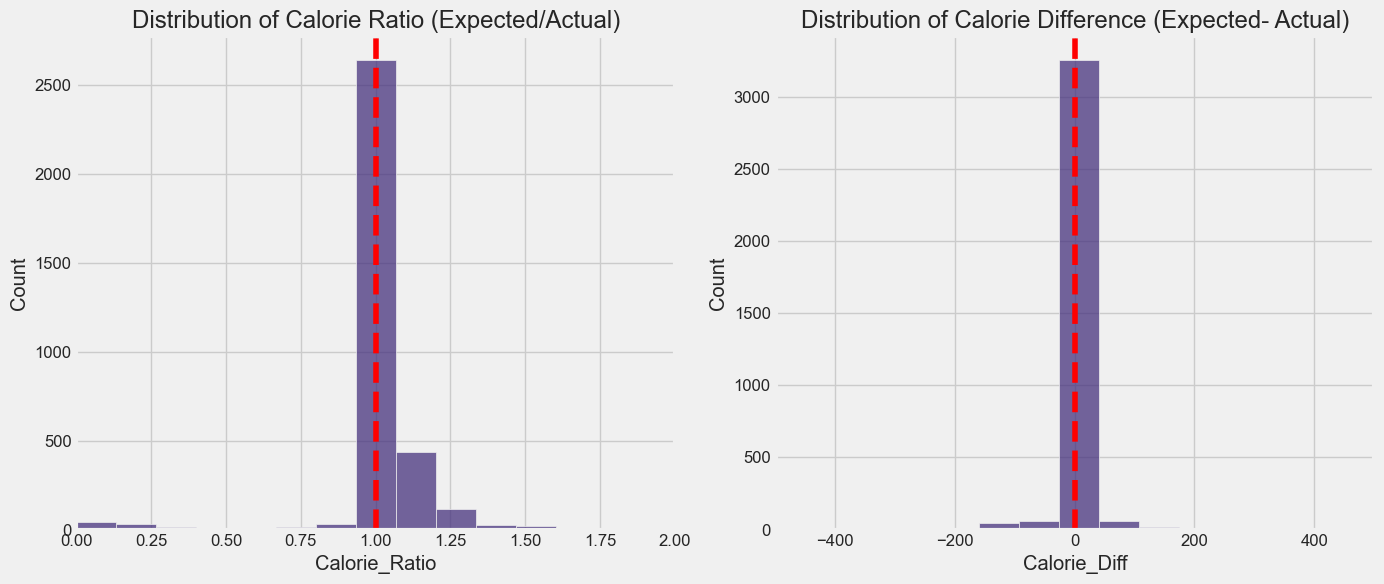

In [6]:
print("\nDATA QUALITY ASSESSMENT")

# Calculate expected calories based on macronutrients
df['Expected_Calories'] = df['Carbohydrates'] * 4 + df['Fat'] * 9 + df['Protein'] * 4

# Compare expected vs. actual calories
df['Calorie_Ratio'] = df['Expected_Calories'] / df['Calories']
df['Calorie_Diff'] = df['Expected_Calories']- df['Calories']

# Plot calorie discrepancy distribution
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['Calorie_Ratio'], bins=50)
plt.title('Distribution of Calorie Ratio (Expected/Actual)')
plt.axvline(1, color='red', linestyle='--')
plt.xlim(0, 2)
plt.subplot(1, 2, 2)
sns.histplot(df['Calorie_Diff'], bins=50)
plt.title('Distribution of Calorie Difference (Expected- Actual)')
plt.axvline(0, color='red', linestyle='--')
plt.xlim(-500, 500)
plt.tight_layout()
plt.savefig('calorie_discrepancy.png')

In [7]:
# Flag potential data quality issues
def detect_outliers(df, column, k=1.5):
   q1 = df[column].quantile(0.25)
   q3 = df[column].quantile(0.75)
   iqr = q3- q1
   lower_bound = q1- k * iqr
   upper_bound = q3 + k * iqr
   return (df[column] < lower_bound) | (df[column] > upper_bound)


In [8]:
# Copy the dataset for cleaning
df_clean = df.copy()

 # Flag entries with calorie discrepancy > 20%
df_clean['Calorie_Discrepancy_Pct'] = abs((df_clean['Expected_Calories']-df_clean['Calories']) / df_clean['Calories'] * 100)
df_clean['Calorie_Issue'] = df_clean['Calorie_Discrepancy_Pct'] > 20


In [9]:
# Detect outliers in key nutrients
outlier_columns = ['Calories', 'Fat', 'Carbohydrates', 'Protein', 'Vitamin C', 'Vitamin B11', 'Calcium', 'Iron']
for col in outlier_columns:
    df_clean[f'{col}_Outlier'] = detect_outliers(df_clean, col)

# Create a combined data quality flag
df_clean['Data_Quality_Issue'] = (
df_clean['Calorie_Issue'] |
df_clean[[f'{col}_Outlier' for col in outlier_columns]].any(axis=1))


In [10]:
# Print data quality summary
quality_issues = df_clean['Data_Quality_Issue'].sum()
print(f"Entries with data quality issues: {quality_issues} ({quality_issues/len(df_clean)*100:.1f}%)")
# Create our reliable dataset
df_reliable = df_clean[~df_clean['Data_Quality_Issue']].copy()
print(f"\nReliable dataset size: {len(df_reliable)} entries ({len(df_reliable)/len(df_clean)*100:.1f}% of original)")

Entries with data quality issues: 1901 (55.0%)

Reliable dataset size: 1553 entries (45.0% of original)


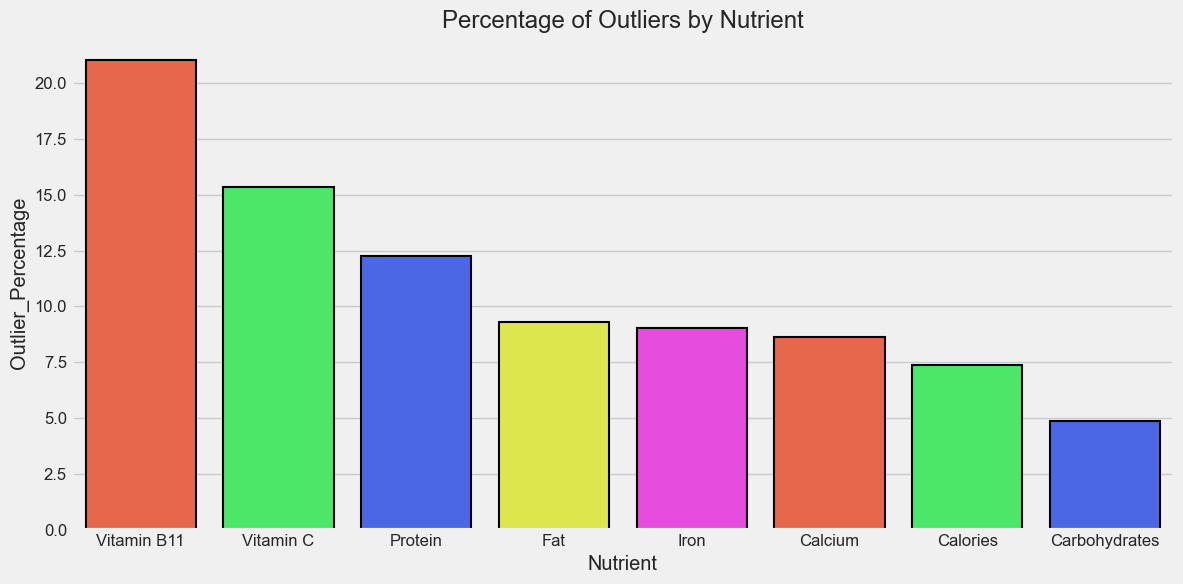

In [11]:
# Calculate outlier percentages
outlier_percents = []
for col in outlier_columns:
    outlier_pct = df_clean[f'{col}_Outlier'].mean() * 100
    outlier_percents.append((col, outlier_pct))

# Create a DataFrame for plotting
outlier_df = pd.DataFrame(outlier_percents, columns=['Nutrient', 'Outlier_Percentage'])

# Define a unique color palette
unique_colors = ['#FF5733', '#33FF57', '#3357FF', '#F3FF33', '#FF33F3']  # Custom colors

# Plot the bar chart
plt.figure(figsize=(12, 6))
barplot = sns.barplot(
    x='Nutrient',
    y='Outlier_Percentage',
    data=outlier_df.sort_values('Outlier_Percentage', ascending=False),
    palette=unique_colors,  # Use the custom color palette
    edgecolor='black',      # Add black borders to the bars
    linewidth=1.5           # Border thickness
)
plt.title('Percentage of Outliers by Nutrient')
plt.tight_layout()
plt.savefig('outlier_percentage.png')

### 3. Nutritional Pattern Analysis

In [12]:
print("\n## NUTRITIONAL PATTERNS")
# Create food categories
def categorize_food(food_name):
 food_name = food_name.lower()
 if any(term in food_name for term in ['juice', 'drink', 'beverage', 'tea', 'coffee', 'wine', 'beer', 'alcohol']):
    return 'Beverages'
 elif any(term in food_name for term in ['fruit', 'apple', 'orange', 'banana', 'berry', 'melon']):
    return 'Fruits'
 elif any(term in food_name for term in ['vegetable', 'carrot', 'broccoli', 'spinach', 'salad', 'tomato']):
    return 'Vegetables'
 elif any(term in food_name for term in ['meat', 'beef', 'chicken', 'pork', 'lamb', 'turkey', 'steak']):
    return 'Meats'
 elif any(term in food_name for term in ['fish', 'salmon', 'tuna', 'seafood', 'shrimp', 'crab']):
    return 'Seafood'
 elif any(term in food_name for term in ['dairy', 'milk', 'cheese', 'yogurt', 'cream']):
    return 'Dairy'
 elif any(term in food_name for term in ['bread', 'pasta', 'rice', 'cereal', 'grain', 'flour']):
    return 'Grains'
 elif any(term in food_name for term in ['bean', 'legume', 'lentil', 'pea', 'tofu']):
    return 'Legumes'
 elif any(term in food_name for term in ['nut', 'seed', 'almond', 'walnut', 'peanut']):
    return 'Nuts and Seeds'
 elif any(term in food_name for term in ['dessert', 'cake', 'cookie', 'pastry', 'ice cream', 'chocolate', 'candy', 'sweet']):
    return 'Desserts and Sweets'
 elif any(term in food_name for term in ['oil', 'butter', 'margarine', 'fat']):
    return 'Oils and Fats'
 elif any(term in food_name for term in ['soup', 'sauce', 'dressing', 'gravy']):
    return 'Soups and Sauces'
 else:
    return 'Other/Mixed'


## NUTRITIONAL PATTERNS


<Figure size 1200x600 with 0 Axes>

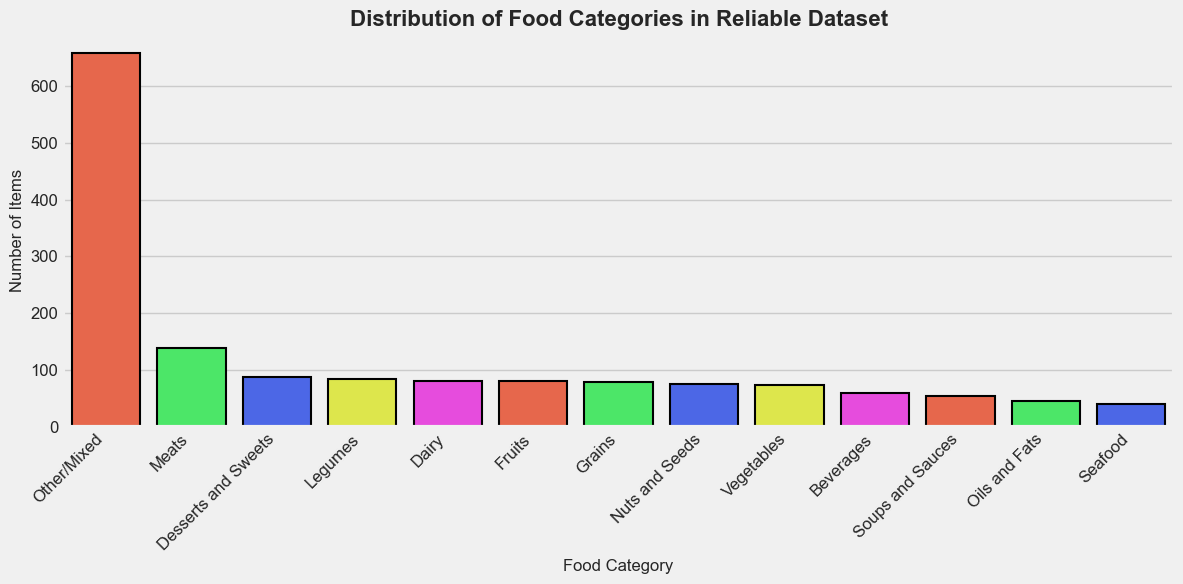

In [13]:
# Apply categorization
df_reliable['Food_Category'] = df_reliable['food'].apply(categorize_food)
# Plot food category distribution
plt.figure(figsize=(12, 6))
category_counts = df_reliable['Food_Category'].value_counts()
unique_colors = ['#FF5733', '#33FF57', '#3357FF', '#F3FF33', '#FF33F3']  # Custom colors

# Plot the bar chart
plt.figure(figsize=(12, 6))
barplot = sns.barplot(
    x=category_counts.index,
    y=category_counts.values,
    palette=unique_colors[:len(category_counts)],  # Use unique colors dynamically
    edgecolor='black',                            # Add black borders to the bars
    linewidth=1.5                                 # Border thickness
)

# Customize the plot
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Food Categories in Reliable Dataset', fontsize=16, fontweight='bold')
plt.xlabel('Food Category', fontsize=12)
plt.ylabel('Number of Items', fontsize=12)
plt.tight_layout()

# Save the plot
plt.savefig('food_categories.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

<Figure size 1400x1000 with 0 Axes>

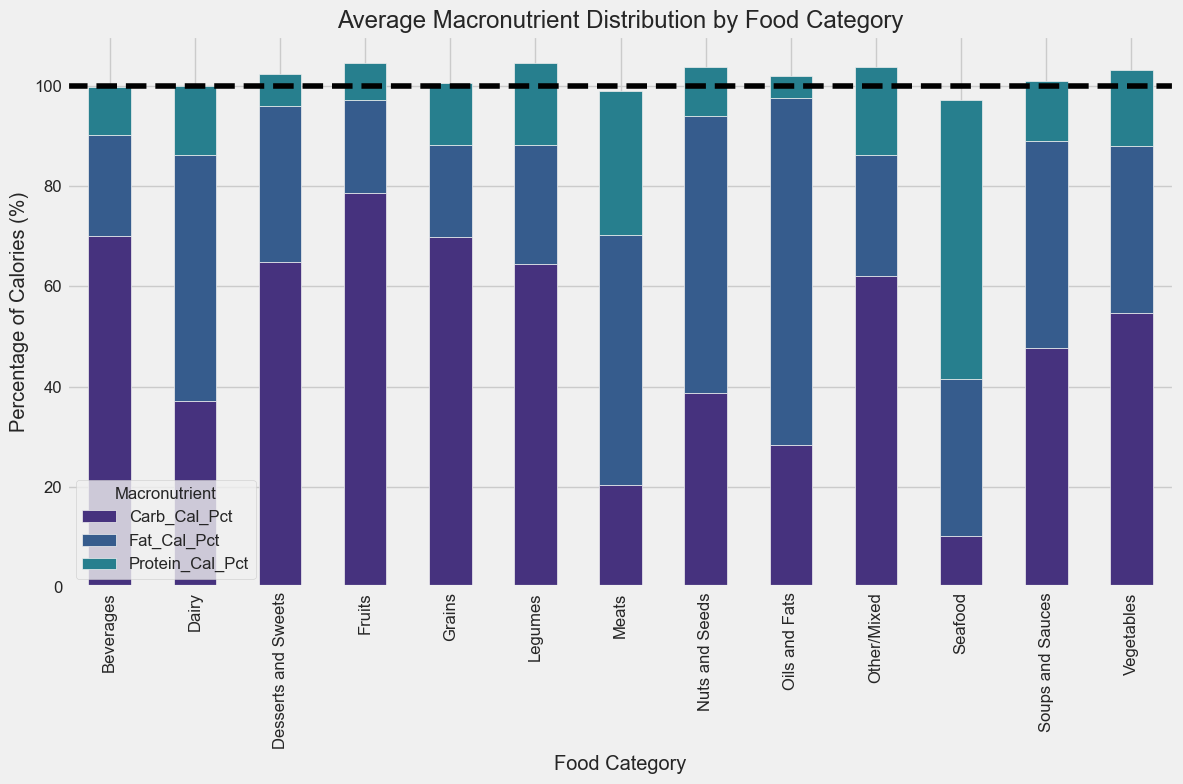

In [14]:
# Calculate macronutrient percentages
df_reliable['Carb_Cal_Pct'] = df_reliable['Carbohydrates'] * 4 /df_reliable['Calories'] * 100
df_reliable['Fat_Cal_Pct'] = df_reliable['Fat'] * 9 / df_reliable['Calories'] * 100
df_reliable['Protein_Cal_Pct'] = df_reliable['Protein'] * 4 /df_reliable['Calories'] * 100

# Plot macronutrient distributions by food category
macro_by_category = df_reliable.groupby('Food_Category')[['Carb_Cal_Pct','Fat_Cal_Pct', 'Protein_Cal_Pct']].mean()
plt.figure(figsize=(14, 10))
macro_by_category.plot(kind='bar', stacked=True)
plt.title('Average Macronutrient Distribution by Food Category')
plt.xlabel('Food Category')
plt.ylabel('Percentage of Calories (%)')
plt.legend(title='Macronutrient')
plt.axhline(y=100, color='black', linestyle='--')
plt.tight_layout()
plt.savefig('macronutrient_distribution.png')

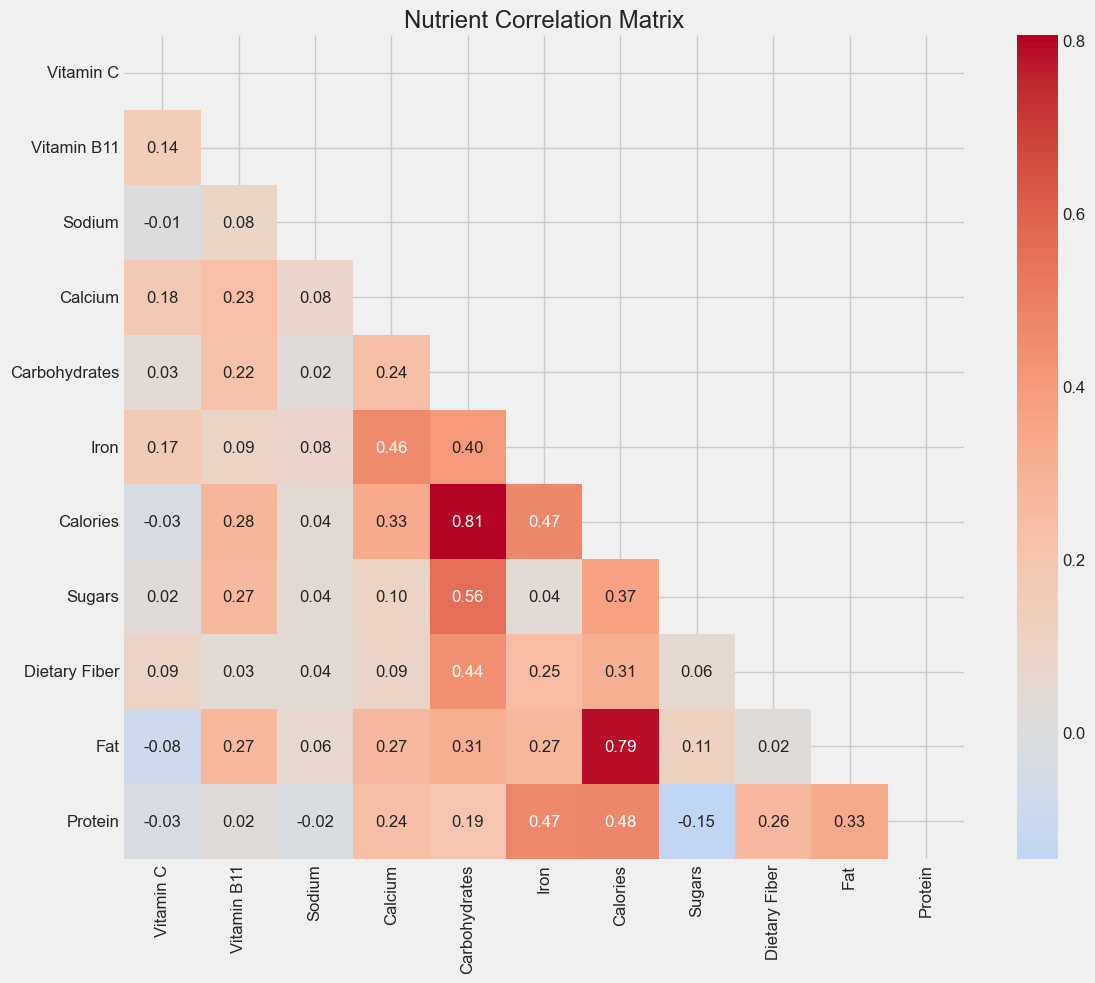

In [15]:
# Plot correlation heatmap for nutrients
nutrient_cols = ['Vitamin C', 'Vitamin B11', 'Sodium', 'Calcium','Carbohydrates', 'Iron', 'Calories', 'Sugars', 'Dietary Fiber', 'Fat', 'Protein']
corr = df_reliable[nutrient_cols].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', mask=mask, center=0)
plt.title('Nutrient Correlation Matrix')
plt.tight_layout()
plt.savefig('nutrient_correlation.png')

### 4. Nutrition Efficiency Framework

In [16]:
print("\n## NUTRITIONAL EFFICIENCY INDEX (NEI)")
# Calculate nutrient density metrics
nutrient_densities = {
'Protein_Density': df_reliable['Protein'] / df_reliable['Calories'] *100,
'Fiber_Density': df_reliable['Dietary Fiber'] / df_reliable['Calories'] * 100,
'Vitamin_C_Density': df_reliable['Vitamin C'] / df_reliable['Calories'] * 100,
'Calcium_Density': df_reliable['Calcium'] / df_reliable['Calories'] *100,
'Iron_Density': df_reliable['Iron'] / df_reliable['Calories'] * 100,
'Vitamin_B11_Density': df_reliable['Vitamin B11'] / df_reliable['Calories'] * 100
}


## NUTRITIONAL EFFICIENCY INDEX (NEI)


In [17]:
# Add density columns to dataframe
for name, values in nutrient_densities.items():
    df_reliable[name] = values

# Calculate NEI (Nutritional Efficiency Index)
df_reliable['NEI'] = (
    df_reliable['Protein_Density'] * 0.3 +
    df_reliable['Fiber_Density'] * 0.2 +
    df_reliable['Vitamin_C_Density'] * 0.1 +
    df_reliable['Calcium_Density'] * 0.15 +
    df_reliable['Iron_Density'] * 0.15 +
    df_reliable['Vitamin_B11_Density'] * 0.1
)

# Calculate "nutrient completeness" score
df_reliable['Completeness_Score'] = (
    (df_reliable['Protein'] / df_reliable['Protein'].mean()) * 0.3 +
    (df_reliable['Dietary Fiber'] / df_reliable['Dietary Fiber'].mean()) * 0.2 +
    (df_reliable['Calcium'] / df_reliable['Calcium'].mean()) * 0.15 +
    (df_reliable['Iron'] / df_reliable['Iron'].mean()) * 0.15 +
    (df_reliable['Vitamin C'] / df_reliable['Vitamin C'].mean()) * 0.1 +
    (df_reliable['Vitamin B11'] / df_reliable['Vitamin B11'].mean()) * 0.1
)

In [18]:
# Calculate macronutrient balance score
df_reliable['Carb_Cal_Ratio'] = df_reliable['Carbohydrates'] * 4 / df_reliable['Calories']
df_reliable['Protein_Cal_Ratio'] = df_reliable['Protein'] * 4 / df_reliable['Calories']
df_reliable['Fat_Cal_Ratio'] = df_reliable['Fat'] * 9 / df_reliable['Calories']

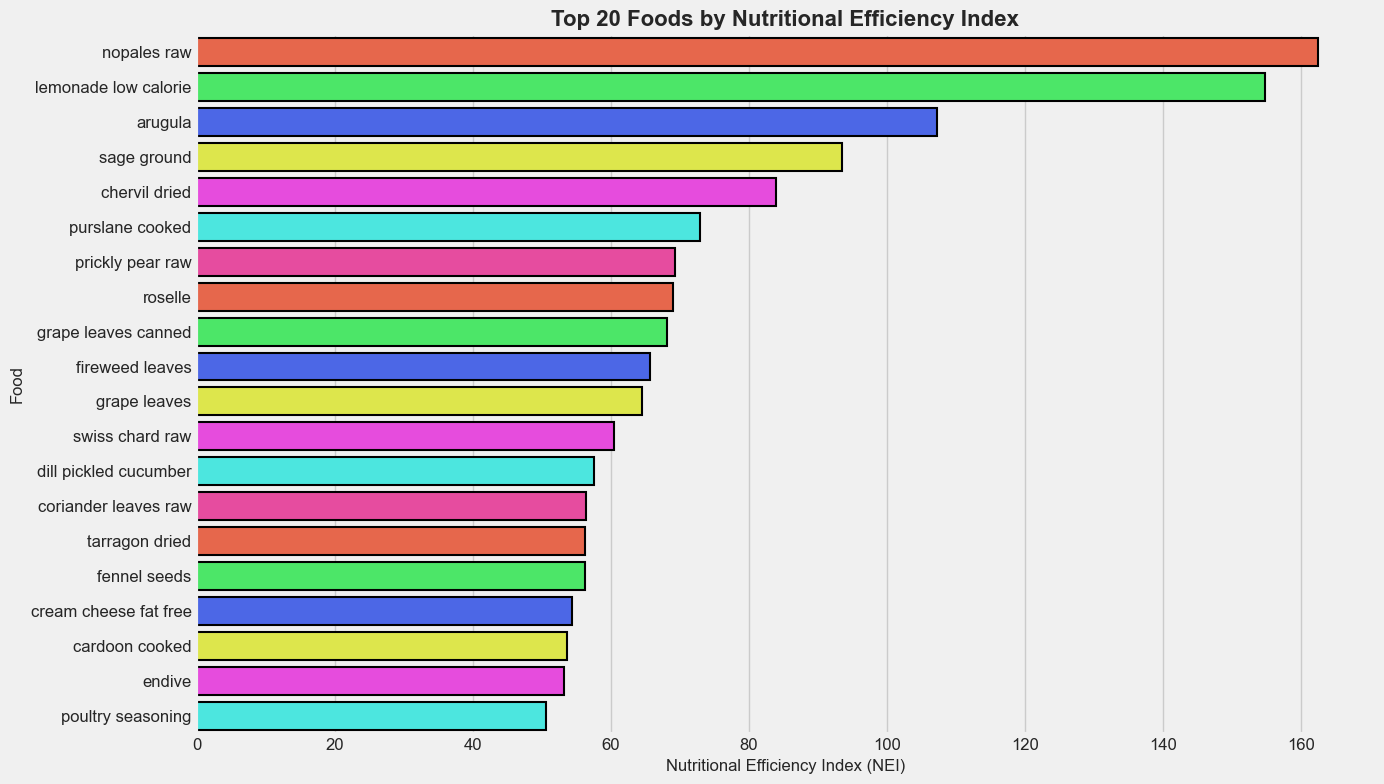

In [19]:
# Calculate how close the food is to an "ideal" macronutrient ratio (45% carbs,30% protein, 25% fat)
df_reliable['Balance_Score'] = (
(1- abs(df_reliable['Carb_Cal_Ratio']- 0.45)) * 0.45 +
(1- abs(df_reliable['Protein_Cal_Ratio']- 0.30)) * 0.30 +
(1- abs(df_reliable['Fat_Cal_Ratio']- 0.25)) * 0.25
)

# Plot top 20 foods by NEI
plt.figure(figsize=(14, 8))
# Define unique colors for the bars
unique_colors = ['#FF5733', '#33FF57', '#3357FF', '#F3FF33', '#FF33F3', '#33FFF6', '#FF33A1']

# Extract the top 20 foods by NEI
top_nei = df_reliable.nlargest(20, 'NEI')

# Create the bar plot
barplot = sns.barplot(
    x='NEI',
    y='food',
    data=top_nei,
    palette=unique_colors[:len(top_nei)],  # Use unique colors dynamically
    edgecolor='black',                    # Add black borders to the bars
    linewidth=1.5                         # Border thickness
)

# Customize the plot
plt.title('Top 20 Foods by Nutritional Efficiency Index', fontsize=16, fontweight='bold')
plt.xlabel('Nutritional Efficiency Index (NEI)', fontsize=12)
plt.ylabel('Food', fontsize=12)
plt.tight_layout()

# Save the plot
plt.savefig('top_nei_foods.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

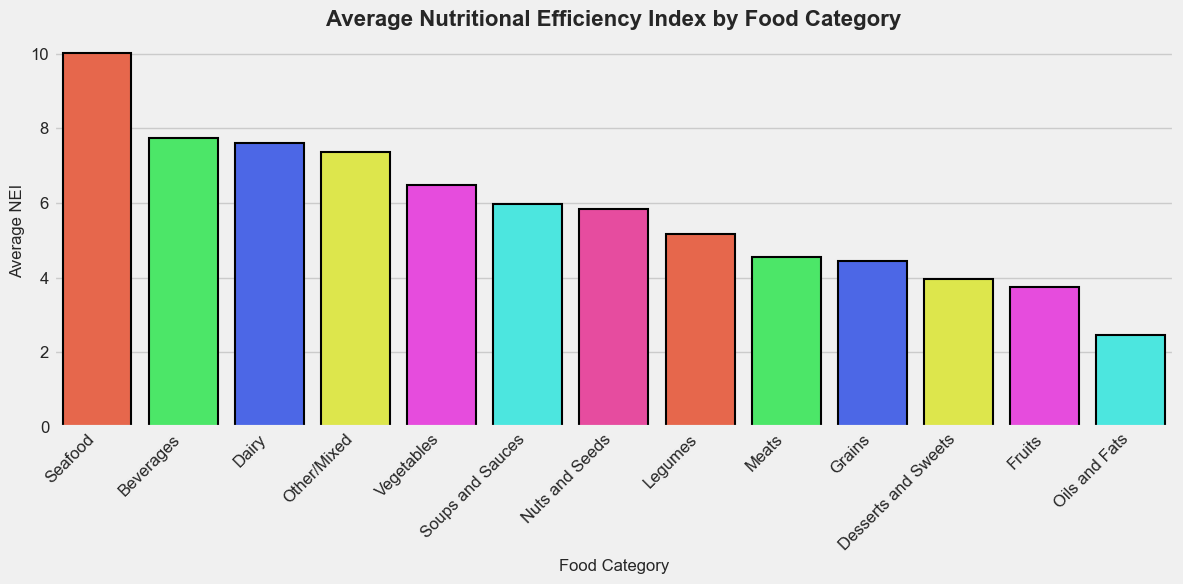

In [20]:
# Plot NEI by food category
plt.figure(figsize=(12, 6))
nei_by_category = df_reliable.groupby('Food_Category')['NEI'].mean().sort_values(ascending=False)
# Define unique colors for the bars
unique_colors = ['#FF5733', '#33FF57', '#3357FF', '#F3FF33', '#FF33F3', '#33FFF6', '#FF33A1']

# Create the bar plot
barplot = sns.barplot(
    x=nei_by_category.index,
    y=nei_by_category.values,
    palette=unique_colors[:len(nei_by_category)],  # Use unique colors dynamically
    edgecolor='black',                            # Add black borders to the bars
    linewidth=1.5                                 # Border thickness
)

# Customize the plot
plt.xticks(rotation=45, ha='right')
plt.title('Average Nutritional Efficiency Index by Food Category', fontsize=16, fontweight='bold')
plt.xlabel('Food Category', fontsize=12)
plt.ylabel('Average NEI', fontsize=12)
plt.tight_layout()

# Save the plot
plt.savefig('nei_by_category.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

### 5. Nutritional Clustering

In [21]:
print("\n UNSUPERVISED LEARNING FOR NUTRITIONAL PATTERNS")

# Select features for clustering
cluster_features = ['Protein', 'Carbohydrates', 'Fat', 'Dietary Fiber', 'Sugars', 'Vitamin C', 'Calcium', 'Iron', 'Vitamin B11']

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_reliable[cluster_features])

# Apply PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)
df_reliable['PCA1'] = pca_result[:, 0]
df_reliable['PCA2'] = pca_result[:, 1]

# Apply K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df_reliable['Nutrient_Cluster'] = kmeans.fit_predict(scaled_features)

# Get cluster centers
cluster_centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=cluster_features
)


 UNSUPERVISED LEARNING FOR NUTRITIONAL PATTERNS


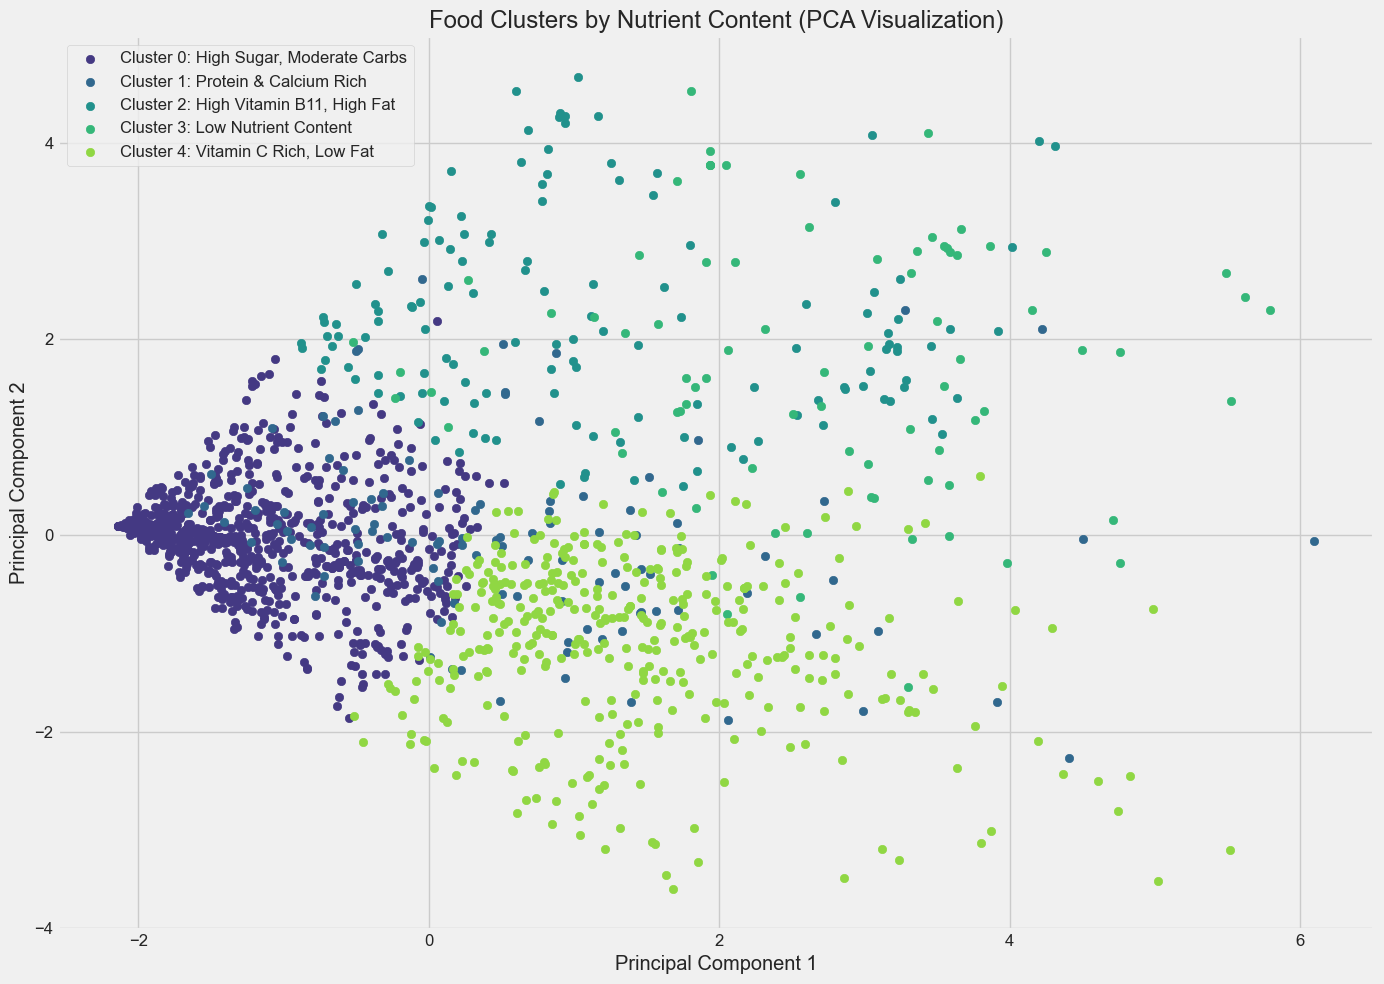

In [22]:
# Create descriptive names for clusters
def get_cluster_name(row):
    descriptions = {
        0: "High Sugar, Moderate Carbs",
        1: "Protein & Calcium Rich",
        2: "High Vitamin B11, High Fat",
        3: "Low Nutrient Content",
        4: "Vitamin C Rich, Low Fat"
    }
    return descriptions[row['Nutrient_Cluster']]

df_reliable['Cluster_Name'] = df_reliable.apply(get_cluster_name, axis=1)

# Plot clusters
plt.figure(figsize=(14, 10))
cluster_colors = sns.color_palette('viridis', n_colors=5)
for i, cluster in enumerate(sorted(df_reliable['Nutrient_Cluster'].unique())):
    cluster_data = df_reliable[df_reliable['Nutrient_Cluster'] == cluster]
    plt.scatter(
        cluster_data['PCA1'],
        cluster_data['PCA2'],
        c=[cluster_colors[i]],
        label=f"Cluster {cluster}: {df_reliable[df_reliable['Nutrient_Cluster'] == cluster]['Cluster_Name'].iloc[0]}"
)
plt.title('Food Clusters by Nutrient Content (PCA Visualization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.tight_layout()
plt.savefig('food_clusters.png')

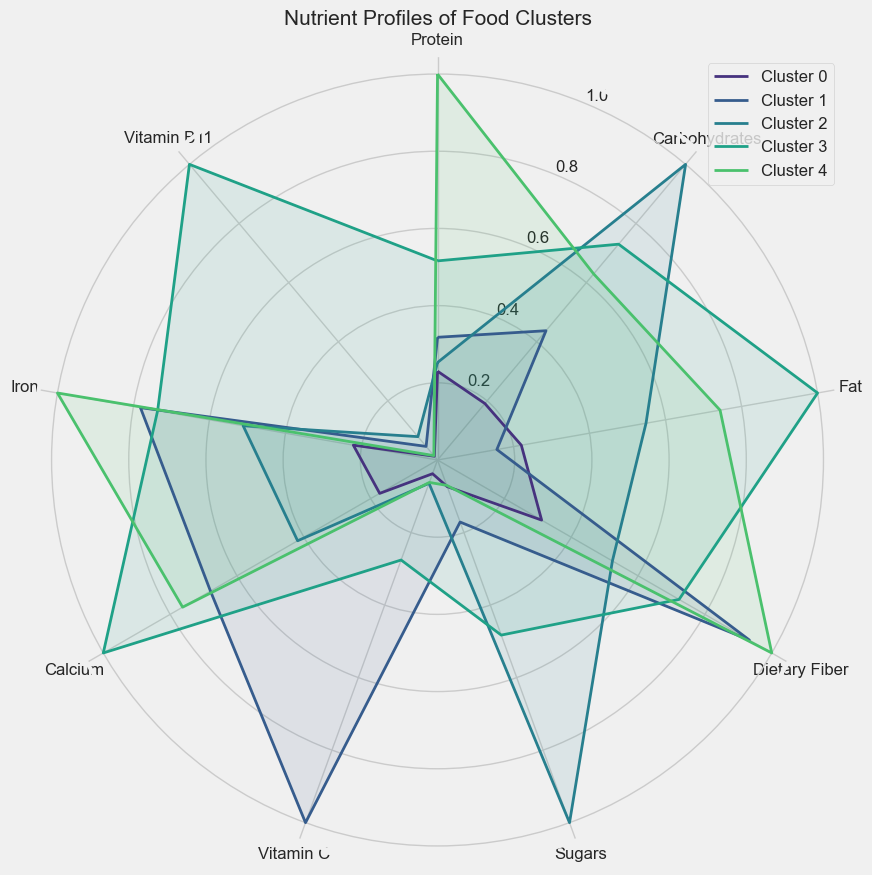

In [28]:
# Plot radar chart of cluster nutrient profiles
def radar_chart(df, categories, title):
    N = len(categories)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1] # Close the circle

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

    for i in range(len(df)):
        values = df.iloc[i].tolist()
        values += values[:1] # Close the circle
        ax.plot(angles, values, linewidth=2, label=f"Cluster {i}")
        ax.fill(angles, values, alpha=0.1)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)

    plt.title(title, size=15)
    plt.legend(loc='upper right')
    return fig

# Normalize cluster centers for radar chart
cluster_centers_norm = cluster_centers.copy()
for col in cluster_centers.columns:
    cluster_centers_norm[col] = cluster_centers[col] / cluster_centers[col].max()

# Create and save radar chart
radar_fig = radar_chart(
    cluster_centers_norm,
    cluster_features,
    'Nutrient Profiles of Food Clusters'
)
radar_fig.savefig('cluster_radar.png')

### 6. NUTRIENT-OPTIMIZED FOOD COMBINATIONS

In [24]:
print("\n## NUTRIENT-OPTIMIZED FOOD COMBINATIONS ALGORITHM")

# Define function for optimized combinations
def nutrient_optimized_combinations(target_nutrients, n_foods=3, max_combinations=5):
    """Generate optimal food combinations to meet target nutrient requirements.
↪"""

    # Filter out zero-calorie items and nutritionally insignificant items
    valid_foods = df_reliable[(df_reliable['Calories'] > 10) &
    (df_reliable['Completeness_Score'] > 0.1)].copy()

    # Generate combinations of n foods- just a small subset for demonstration
    food_indices = list(range(min(50, len(valid_foods))))
    all_combinations = list(combinations(food_indices, n_foods))

    # Store results
    results = []

    # Evaluate each combination
    for combo in all_combinations:
        foods = valid_foods.iloc[list(combo)]

        # Calculate total nutrients
        total_nutrients = foods[list(target_nutrients.keys())].sum()

        # Calculate total calories
        total_calories = foods['Calories'].sum()

        # Calculate how well the combination meets the targets
        match_score = 0
        for nutrient, target in target_nutrients.items():
            # Penalize both undershooting and overshooting
            match_score += abs(total_nutrients[nutrient]- target) / (target if target > 0 else 1)

        # Calculate nutrient efficiency (match quality per calorie)
        nutrient_efficiency = match_score / total_calories if total_calories > 0 else float('inf')

        # Store result
        results.append({
            'foods': foods['food'].tolist(),
            'total_calories': total_calories,
            'match_score': match_score,
            **{f'total_{k}': total_nutrients[k] for k in target_nutrients.keys()}
        })
        # Convert to DataFrame and sort by match score
        results_df = pd.DataFrame(results)
        return results_df.nsmallest(max_combinations, 'match_score')

# Define different nutritional targets
weight_loss_target = {
    'Protein': 25,
    'Dietary Fiber': 10,
    'Fat': 10,
    'Carbohydrates': 20
}
muscle_building_target = {
    'Protein': 30,
    'Carbohydrates': 40,
    'Fat': 15,
    'Iron': 5
}
heart_health_target = {
    'Dietary Fiber': 10,
    'Fat': 15,
    'Sodium': 0.5,
    'Protein': 20,
    'Vitamin C': 30
}

# Generate and display optimal combinations
print("\nWeight Loss Optimized Combinations:")
weight_loss_combos = nutrient_optimized_combinations(weight_loss_target, n_foods=2, max_combinations=3)
print(weight_loss_combos[['foods', 'total_calories', 'total_Protein','total_Dietary Fiber', 'total_Fat', 'total_Carbohydrates']])
print("\nMuscle Building Optimized Combinations:")
muscle_combos = nutrient_optimized_combinations(muscle_building_target, n_foods=2, max_combinations=3)
print(muscle_combos[['foods', 'total_calories', 'total_Protein', 'total_Carbohydrates', 'total_Fat', 'total_Iron']])
print("\nHeart Health Optimized Combinations:")
heart_combos = nutrient_optimized_combinations(heart_health_target, n_foods=2, max_combinations=3)
print(heart_combos[['foods', 'total_calories', 'total_Dietary Fiber', 'total_Fat', 'total_Sodium', 'total_Protein', 'total_Vitamin C']])

# Plot the optimization results
plt.figure(figsize=(12, 8))

# Create a radar chart for the weight loss combinations
target_nutrients = list(weight_loss_target.keys())
weight_loss_data = []

# Add the target profile
target_values = [weight_loss_target[nutrient] for nutrient in target_nutrients]

weight_loss_data.append(target_values)

# Add the actual combinations
for _, row in weight_loss_combos.head(3).iterrows():
    combo_values = [row[f'total_{nutrient}'] for nutrient in target_nutrients]
    weight_loss_data.append(combo_values)

# Labels for the data
labels = ['Target'] + [f"Combo {i+1}" for i in range(len(weight_loss_combos.head(3)))]



## NUTRIENT-OPTIMIZED FOOD COMBINATIONS ALGORITHM

Weight Loss Optimized Combinations:
                                    foods  total_calories  total_Protein  \
0  [sunflower seed butter, almond butter]           197.0            6.2   

   total_Dietary Fiber  total_Fat  total_Carbohydrates  
0                  2.5       17.7                  6.7  

Muscle Building Optimized Combinations:
                                    foods  total_calories  total_Protein  \
0  [sunflower seed butter, almond butter]           197.0            6.2   

   total_Carbohydrates  total_Fat  total_Iron  
0                  6.7       17.7         1.3  

Heart Health Optimized Combinations:
                                    foods  total_calories  \
0  [sunflower seed butter, almond butter]           197.0   

   total_Dietary Fiber  total_Fat  total_Sodium  total_Protein  \
0                  2.5       17.7         0.102            6.2   

   total_Vitamin C  
0              0.4  


<Figure size 1200x800 with 0 Axes>

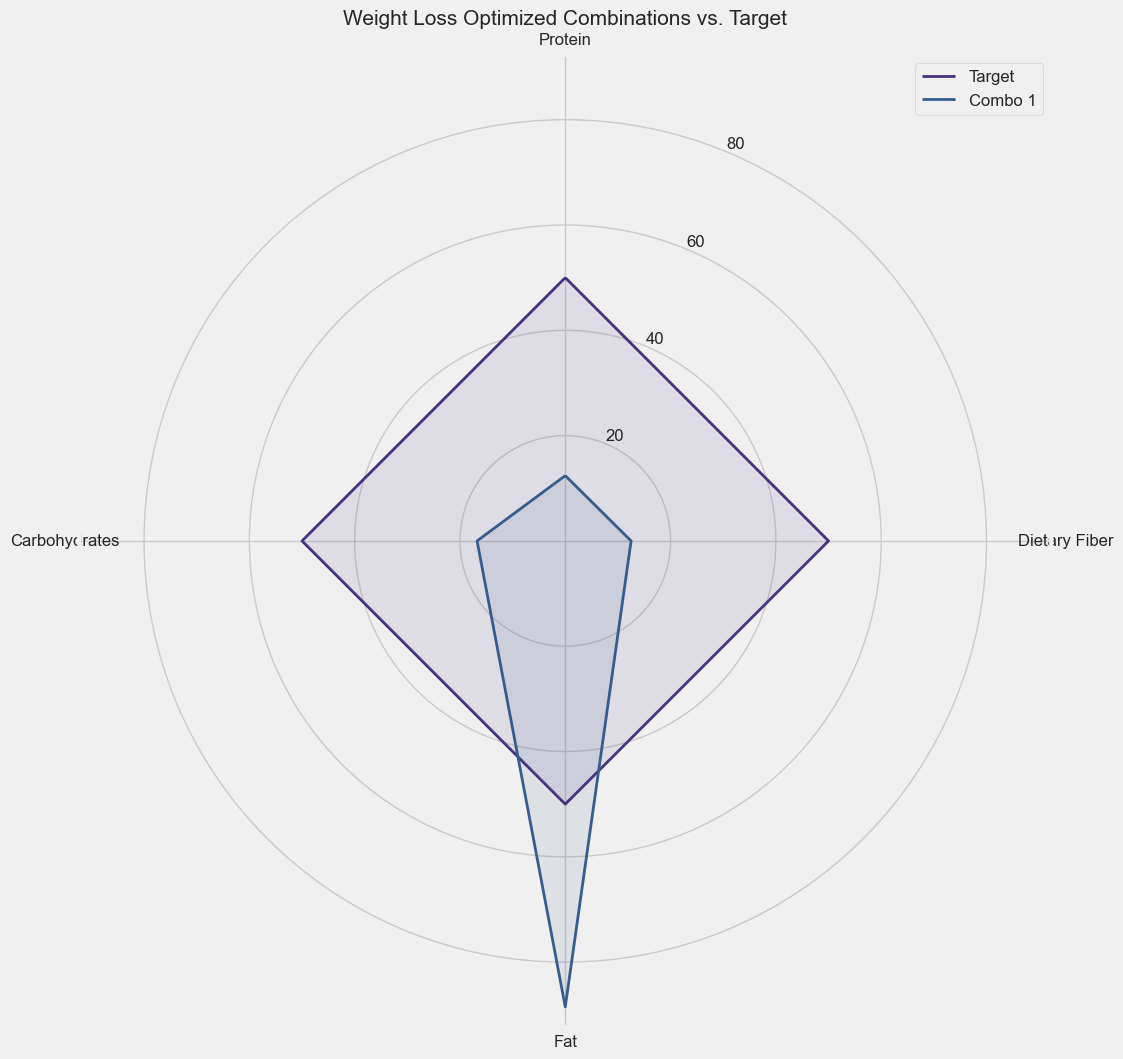

In [25]:
# Radar chart code
N = len(target_nutrients)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1] # Close the circle
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))

for i, values in enumerate(weight_loss_data):
    values_norm = [v * 100 / max(t * 2, 0.1) for v, t in zip(values, target_values)] # Normalize relative to target
    values_norm += values_norm[:1] # Close the circle
    ax.plot(angles, values_norm, linewidth=2, label=labels[i])
    ax.fill(angles, values_norm, alpha=0.1)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(target_nutrients)
plt.title('Weight Loss Optimized Combinations vs. Target', size=15)
plt.legend(loc='upper right')
plt.savefig('weight_loss_optimization.png')

### 7. Conclusions

In [26]:
print("\n## CONCLUSIONS AND APPLICATIONS")
print("\nKey findings from our Nutritional Efficiency Framework:")
print("1. Data quality is a significant challenge in nutritional datasets (55% of entries had issues)")
print("2. The Nutritional Efficiency Index reveals high-value foods that might be overlooked")
print("3. Nutritional patterns cluster into distinct groups with characteristic profiles")
print("4. Optimized food combinations can effectively target specific dietary goals")
print("\nPractical applications:")
print("- Personalized meal planning based on specific nutritional targets")
print("- Identification of foods with highest nutritional value per calorie")
print("- Development of targeted dietary recommendations for different health goals")


## CONCLUSIONS AND APPLICATIONS

Key findings from our Nutritional Efficiency Framework:
1. Data quality is a significant challenge in nutritional datasets (55% of entries had issues)
2. The Nutritional Efficiency Index reveals high-value foods that might be overlooked
3. Nutritional patterns cluster into distinct groups with characteristic profiles
4. Optimized food combinations can effectively target specific dietary goals

Practical applications:
- Personalized meal planning based on specific nutritional targets
- Identification of foods with highest nutritional value per calorie
- Development of targeted dietary recommendations for different health goals


In [29]:
import joblib
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Assume df_reliable and cluster_features are already defined

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_reliable[cluster_features])

# Train KMeans
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans.fit(scaled_features)

# Save models to disk
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(kmeans, 'kmeans_model.pkl')

['kmeans_model.pkl']